In [86]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))
import importlib
import funs
importlib.reload(funs) # prevents caching
from funs import get_merged_dataframes

Import data and merge dataframes

In [87]:
full_data = get_merged_dataframes()

Basic Cleaning & Feature Engineering

In [88]:
# Missing values
full_data['education'] = full_data['education'].fillna('Missing')

# Aggregates by merchant and user
full_data['fraud_transactions_per_merchant'] = full_data.groupby('merchant_id')['is_fraud'].transform('sum')
full_data['transactions_per_merchant'] = full_data.groupby('merchant_id')['is_fraud'].transform('count')
full_data['fraud_transactions_per_user'] = full_data.groupby('user_id')['is_fraud'].transform('sum')
full_data['transactions_per_user'] = full_data.groupby('user_id')['is_fraud'].transform('count')

# Fraud ratios
full_data['fraud_ratio_per_merchant'] = (
    full_data['fraud_transactions_per_merchant'] / full_data['transactions_per_merchant']
)
full_data['fraud_ratio_per_user'] = (
    full_data['fraud_transactions_per_user'] / full_data['transactions_per_user']
)

# Timestamp -> datetime
full_data['timestamp'] = pd.to_datetime(full_data['timestamp'])
full_data['signup_date'] = pd.to_datetime(full_data['signup_date'])
full_data['hour'] = full_data['timestamp'].dt.hour
full_data['day_of_week'] = full_data['timestamp'].dt.dayofweek
full_data['days_since_signup'] = (full_data['timestamp'] - full_data['signup_date']).dt.days

# Amount avg
user_avg = full_data.groupby('user_id')['amount'].transform('mean')
full_data['amount_to_user_avg'] = full_data['amount'] / (user_avg + 1e-5)  # Avoid division by zero


# Rolling transaction count over the last 7 days
full_data = full_data.sort_values(['user_id', 'timestamp'])

def rolling_txn_count(df):
    df = df.set_index('timestamp')
    return df['transaction_id'].rolling('7d').count()

full_data['txn_count_last_7d'] = (
    full_data
    .groupby('user_id', group_keys=False)[['timestamp', 'transaction_id']]
    .apply(rolling_txn_count)
    .reset_index(drop=True)
)

full_data['is_first_ever_transaction'] = (
    full_data.groupby('user_id').cumcount() == 0
).astype(int)

# Other ratios
full_data['expense_income_ratio'] = full_data['sum_of_monthly_expenses'] / (full_data['sum_of_monthly_installments'] + 1e-5)
full_data['txn_to_expense_ratio'] = full_data['amount'] / (full_data['sum_of_monthly_expenses'] + 1e-5)

One hot encoding

In [89]:
sex_dummies       = pd.get_dummies(full_data['sex'], prefix='sex')
education_dummies = pd.get_dummies(full_data['education'], prefix='education')
income_dummies    = pd.get_dummies(full_data['primary_source_of_income'], prefix='primary_income')
category_dummies  = pd.get_dummies(full_data['category'], prefix='category')
user_country_dummies = pd.get_dummies(full_data['user_country'], prefix='user_country')
merchant_country_dummies = pd.get_dummies(full_data['merchant_country'], prefix='merchant_country')

# Merge all dummies
full_data = pd.concat([
    full_data.drop(['category', 'user_country', 'merchant_country'], axis=1),
    sex_dummies,
    education_dummies,
    income_dummies,
    category_dummies,
    user_country_dummies,
    merchant_country_dummies
], axis=1)

for col in ['channel', 'device', 'payment_method', 'education']:
    freq = full_data[col].value_counts(normalize=True)
    full_data[f'{col}_freq'] = full_data[col].map(freq)

Filtered correlation heatmap

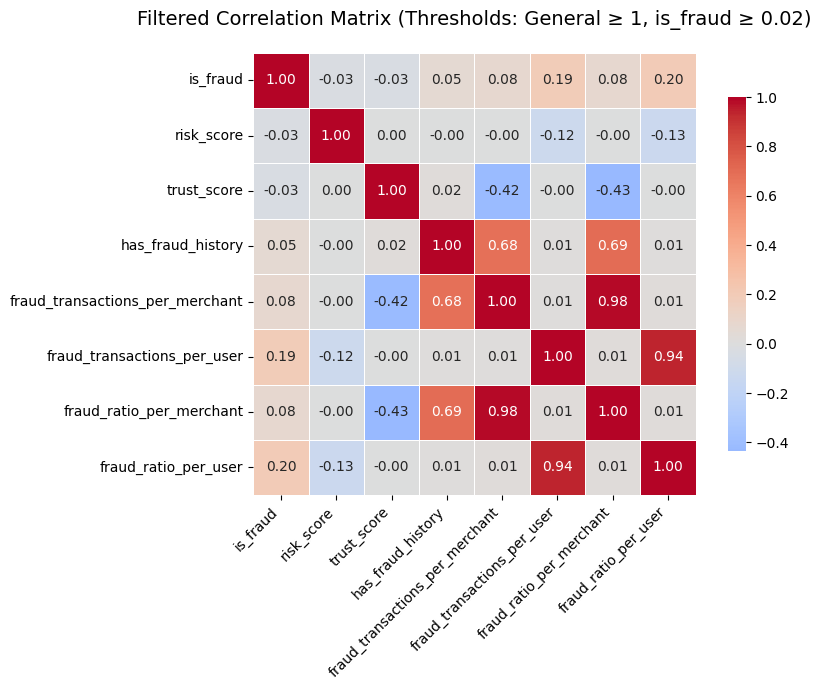

In [93]:
numeric_data = full_data.select_dtypes(include=['number', 'bool'])
corr_matrix = numeric_data.corr()

threshold_general = 1       # general correlation threshold
threshold_target = 0.02     # correlation with is_fraud

# Remove diagonal self-correlation
corr_no_diag = corr_matrix.copy()
np.fill_diagonal(corr_no_diag.values, 0)

condition_general = (np.abs(corr_no_diag) >= threshold_general).any(axis=0)
condition_target = np.abs(corr_matrix['is_fraud']) >= threshold_target
keep_columns = condition_general | condition_target
filtered_corr = corr_matrix.loc[keep_columns, keep_columns]

plt.figure(figsize=(9, 7))
sns.heatmap(
    filtered_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title(f'Filtered Correlation Matrix (Thresholds: General ≥ {threshold_general}, is_fraud ≥ {threshold_target})',
          pad=20, fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [95]:
# save full_data as csv in ../../data/
output_dir = Path.cwd().parent.parent / 'data'
output_dir.mkdir(parents=True, exist_ok=True)   
output_file = output_dir / 'full_data.csv'
full_data.to_csv(output_file, index=False)